# Project group 30

# What is the correlation between a country's corruption perception index and their likelihood of being awarded a medal during the Olympic Games?

In [1]:
#read necessary libraries 
import numpy as np
import pandas as pd
import pycountry
import pycountry_convert as pcc
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
np.set_printoptions(precision = 4, suppress = True)

/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Necesarry installations:

In [2]:
#pip install pycountry_convert
#pip install fuzzywuzzy

In [3]:
#loading the csv files into dataframes
population = 'population.csv'
df_population= pd.read_csv(population)
medals = 'medals.csv'
df_medals= pd.read_csv(medals)
cpi = 'cpi.csv'
df_cpi= pd.read_csv(cpi)
df_happiness = pd.read_csv('world-happiness-report-2021.csv')
df_population_density = pd.read_csv('population_by_country_2020.csv')
df_drinking = pd.read_csv('drinks.csv')

In [4]:
def normalize_countries(dataframe, name_country_column):

    # Create a list of all unique countries in the dataframe

    countries = dataframe[name_country_column].unique().tolist()

    #Create a list of all standard country names
    countries_standard = [country.name for country in pycountry.countries]

    for i in range(len(dataframe)):
        temp = dataframe[name_country_column][i]
        country = 'c'
        try:
            country = pycountry.countries.lookup(temp)
        except LookupError as e:
            pass
        if country == 'c':
            try:
                match = process.extractOne(str(temp), countries_standard, scorer=fuzz.token_sort_ratio)
                if match[1] > 74:
                    c = pycountry.countries.get(name=match[0])
                    country_code=c.alpha_3
                    dataframe.loc[i, name_country_column] = country_code
                else:
                    dataframe.loc[i, name_country_column] = None
            except ValueError as e:
                dataframe.loc[i, name_country_column] = None
        else:
            dataframe.loc[i, name_country_column] = country.alpha_3


# Create a list of all unique countries in the dataframe
countries = df_medals['Country'].unique().tolist()

#Create a list of all standard country names
countries_standard = [country.name for country in pycountry.countries]

for i in range(len(df_medals)):
    temp = df_medals['Country'][i]
    country = 'c'
    try:
        country = pycountry.countries.lookup(temp)
    except LookupError as e:
        pass
    if country == 'c':
        try:
            match = process.extractOne(str(temp), countries_standard, scorer=fuzz.token_sort_ratio)
            if match[1] > 74:
                c = pycountry.countries.get(name=match[0])
                country_code=c.alpha_3
                df_medals.loc[i, 'Country'] = country_code
            else:
                df_medals.loc[i, 'Country'] = None
        except ValueError as e:
            df_medals.loc[i, 'Country'] = None
    else:
        df_medals.loc[i, 'Country'] = country.alpha_3


#manually converting few instances
#Kosovo doesn't have ISO3
df_medals.at[3, 'Country'] = 'GBR'
df_medals.at[4, 'Country'] = 'RUS'
df_medals.at[33, 'Country'] = 'TWN'

In [5]:
normalize_countries(df_medals, 'Country')

#manually converting few instances
#Kosovo doesn't have ISO3
df_medals.at[3, 'Country'] = 'GBR'
df_medals.at[4, 'Country'] = 'RUS'
df_medals.at[33, 'Country'] = 'TWN'

Display the original table with "Gold Medal", "Silver Medal" and "Bronze Medal" columns:

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
   print(df_medals)

   Country  Gold Medal  Silver Medal  Bronze Medal  Total  Rank By Total
0      USA          39            41            33    113              1
1      CHN          38            32            18     88              2
2      JPN          27            14            17     58              5
3      GBR          22            21            22     65              4
4      RUS          20            28            23     71              3
5      AUS          17             7            22     46              6
6      NLD          10            12            14     36              9
7      FRA          10            12            11     33             10
8      DEU          10            11            16     37              8
9      ITA          10            10            20     40              7
10     CAN           7             6            11     24             11
11     BRA           7             6             8     21             12
12     NZL           7             6             7 

# Methodology

Medals scoring system:
    
    GOLD - 3 points
    SILVER - 2 points
    BRONZE - 1 point


In [7]:
#calculating the value of the medals earned
medal_values=[]
for i in range(len(df_medals)):
    temp_g=df_medals['Gold Medal'][i]
    #print(temp_g)
    temp_s=df_medals['Silver Medal'][i]
    temp_b=df_medals['Bronze Medal'][i]
    value=(temp_g*3)+(temp_s*2)+temp_b
    medal_values.append(value)
df_medals["Medal Value"] = medal_values

In [9]:
#merging medal df with population df
df_merged1 = pd.merge(df_medals, df_population, left_on='Country', right_on='CCA3')

#calculation medal value per million inhabitants
medals_per_million=[]
for i in range(len(df_merged1)):
    medal_adjusted = df_merged1['Medal Value'][i]/(df_merged1['2020 Population'][i]/1000000) 
    medals_per_million.append(medal_adjusted)
df_merged1["Medals per million"] = medals_per_million

#merging the resulting df with cpi df
df_merged2 = pd.merge(df_merged1, df_cpi, left_on='Country', right_on='ISO3', how='left')
df_merged2
df = df_merged2[['Country_x','Medal Value', 'Medals per million','2020 Population', 'CPI score 2019']]
df

   Country_x  Medal Value  Medals per million  2020 Population  CPI score 2019
0        USA          232            0.690595        335942003            69.0
1        CHN          196            0.137551       1424929781            41.0
2        JPN          126            1.006030        125244761            73.0
3        GBR          130            1.938578         67059474            77.0
4        RUS          139            0.954557        145617329            28.0
5        AUS           87            3.389164         25670051            77.0
6        NLD           68            3.900300         17434557            82.0
7        FRA           65            1.008064         64480053            69.0
8        DEU           68            0.816043         83328988            80.0
9        ITA           70            1.176459         59500579            53.0
10       CAN           44            1.161296         37888705            77.0
11       BRA           41            0.192311       

Merging dataframe with Alcohol Consumption

In [10]:
#preparing data
normalize_countries(df_drinking, 'country')
df_drinking = df_drinking[['country', 'total_litres_of_pure_alcohol']]
df_drinking.rename(columns = {'total_litres_of_pure_alcohol':'Alcohol Consumed'}, inplace = True)

#merging
df = pd.merge(df, df_drinking, left_on='Country_x', right_on='country', how='left')
df = df.drop(columns=['country'])


Adding happiness levels to the dataframe

In [11]:
#preparing the dataframe
df_happiness.rename(columns = {'Ladder score':'Happiness score'}, inplace = True)
df_happiness = df_happiness[['Country name', 'Happiness score']]
normalize_countries(df_happiness, 'Country name')


#manually converting some names
df_happiness.at[75, 'Country name'] = 'RUS'
df_happiness.at[117, 'Country name'] = 'IRN'
df_happiness.at[76, 'Country name'] = 'HKG'
df_happiness.at[84, 'Country name'] = 'CIV'

#merging
df = pd.merge(df, df_happiness, left_on='Country_x', right_on='Country name', how='left')
df = df.drop(columns=['Country name'])


Adding population density to the dataframe

In [12]:
#preparing dataframe
df_population_density.rename(columns = {'Country (or dependency)':'Countries'}, inplace = True)
df_population_density.rename(columns = {'Density (P/Km²)':'Population Density (P/Km²)'}, inplace = True)
df_population_density = df_population_density[['Countries', 'Population Density (P/Km²)']]

#manually converting some data to required format
df_population_density.at[8, 'Countries'] = 'RUS'
df_population_density.at[85, 'Countries'] = 'CZE'
df_population_density.at[17, 'Countries'] = 'IRN'
df_population_density.at[67, 'Countries'] = 'SYR'


normalize_countries(df_population_density, 'Countries')

#merging
df = pd.merge(df, df_population_density, left_on='Country_x', right_on='Countries', how='left')
df = df.drop(columns=['Countries'])

Display a modified table with the weighted values of medals:

In [13]:
df

,Country_x,Medal Value,Medals per million,2020 Population,CPI score 2019,Alcohol Consumed,Happiness score,Population Density (P/Km²)
0,USA,232,0.690595,335942003,69.0,8.7,6.951,36
1,CHN,196,0.137551,1424929781,41.0,5.0,5.339,153
2,JPN,126,1.006030,125244761,73.0,7.0,5.940,347
3,GBR,130,1.938578,67059474,77.0,10.4,7.064,281
4,RUS,139,0.954557,145617329,28.0,11.5,5.477,9
...,...,...,...,...,...,...,...,...
88,GHA,1,0.031075,32180401,41.0,1.8,5.088,137
89,GRD,1,8.086493,123663,53.0,11.9,NaN,331
90,KWT,1,0.229334,4360444,40.0,0.0,6.106,240
91,MDA,1,0.324165,3084847,32.0,6.3,5.766,123


# Visualizations

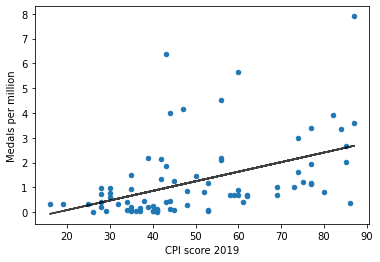

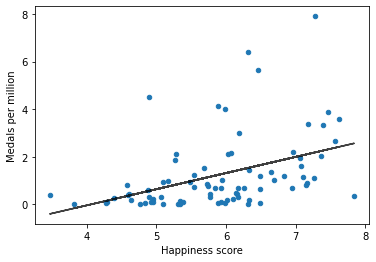

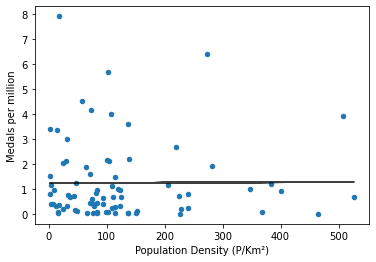

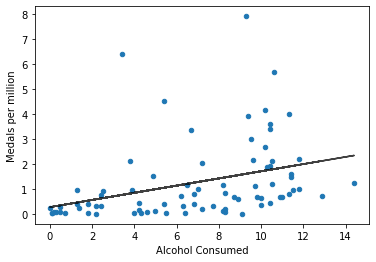

In [14]:

df_no_outliers = df[df['Medals per million']<12].dropna()


#plotting CPI score against medals with trend line
df_no_outliers.plot.scatter(x='CPI score 2019',y='Medals per million')
z = np.polyfit(df_no_outliers['CPI score 2019'], df_no_outliers['Medals per million'], 1)
p = np.poly1d(z) 
plt.plot(df_no_outliers['CPI score 2019'],p(df_no_outliers['CPI score 2019']), 'k', alpha=0.75)

#plotting happiness score against medals with trend line
df_no_outliers.plot.scatter(x='Happiness score',y='Medals per million')
z = np.polyfit(df_no_outliers['Happiness score'], df_no_outliers['Medals per million'], 1)
p = np.poly1d(z) 
plt.plot(df_no_outliers['Happiness score'],p(df_no_outliers['Happiness score']), 'k', alpha=0.75)

#plotting population density against models with trend line
df_no_population_outliers = df[df['Population Density (P/Km²)']<1000].dropna()
df_no_population_outliers.plot.scatter(x='Population Density (P/Km²)',y='Medals per million')
z = np.polyfit(df_no_population_outliers['Population Density (P/Km²)'], df_no_population_outliers['Medals per million'], 1)
p = np.poly1d(z) 
plt.plot(df_no_population_outliers['Population Density (P/Km²)'],p(df_no_population_outliers['Population Density (P/Km²)']), 'k', alpha=0.75)

##plotting alcohol consumption against medals with trend line
df_no_population_outliers.plot.scatter(x='Alcohol Consumed',y='Medals per million')
z = np.polyfit(df_no_population_outliers['Alcohol Consumed'], df_no_population_outliers['Medals per million'], 1)
p = np.poly1d(z) 
plt.plot(df_no_population_outliers['Alcohol Consumed'],p(df_no_population_outliers['Alcohol Consumed']), 'k', alpha=0.75)
